In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_toolkits import mplot3d 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox
from sklearn.preprocessing import RobustScaler

In [2]:
def create_centered_mean(series):
    series = pd.DataFrame(series)
    centered_avg = series.rolling(window = 5)
    centered_avg = centered_avg.mean()
    return centered_avg

In [3]:
def inventory_loading():
    station_data = pd.read_csv('stations_cleaned.csv.gz')
    kmeans = pd.read_csv('kmeans_output')
    kmeans = kmeans.drop('Unnamed: 0', axis = 1)
    station_data = station_data.set_index('dock_name')
    kmeans = kmeans.set_index('start station name')
    station_data = station_data.merge(kmeans, left_index = True, right_on = 'start station name')
    station_data = station_data.reset_index()
    station_data.hour = station_data.hour.astype(str).apply(lambda x: x.zfill(2))
    station_data.loc[station_data['hour'] == '24', 'hour'] = '00'
    station_data.minute = station_data.minute.astype(str).apply(lambda x: x.zfill(2))
    station_data['time'] = station_data.hour + ':' + station_data.minute + ':' +  '00'
    station_data['datetime'] = pd.to_datetime(station_data['date'] + ' ' + station_data['time'])
    station_data = station_data.set_index(station_data['datetime'])
    return station_data

In [4]:
def data_loading():
    rider_df = pd.read_csv('downsampled_rider.csv.gz', 
                  parse_dates = ['starttime', 'stoptime', 'start_date', 'stop_date'])
    station_data = pd.read_csv('stations_cleaned.csv.gz', usecols = ['dock_id','dock_name','date','hour',
                                                                      'minute','avail_bikes','time'])

    kmeans = pd.read_csv('kmeans_output')
    kmeans = kmeans.drop('Unnamed: 0', axis = 1)
    station_data = station_data.set_index('dock_name')
    kmeans = kmeans.set_index('start station name')
    station_data = station_data.merge(kmeans, left_index = True, right_on = 'start station name')
    station_data = station_data.reset_index()
    rider_df = rider_df.set_index('starttime')
    station_data.hour = station_data.hour.astype(str).apply(lambda x: x.zfill(2))
    station_data.loc[station_data['hour'] == '24', 'hour'] = '00'
    station_data.minute = station_data.minute.astype(str).apply(lambda x: x.zfill(2))
    station_data['time'] = station_data.hour + ':' + station_data.minute + ':' +  '00'
    station_data['datetime'] = pd.to_datetime(station_data['date'] + ' ' + station_data['time'])
    station_data = station_data.set_index('datetime')
    station_data = station_data.drop(['date','hour','minute','time'], axis =1)
    non_zero = station_data[station_data['avail_bikes'] != 0].copy()
    rider_df = rider_df.groupby([pd.Grouper(freq = 'd'), 'start station id'])['stoptime'].count()
    non_zero = non_zero.groupby([pd.Grouper(freq = 'd'), 'dock_id'])['cluster'].mean()
    station_data = station_data.groupby([pd.Grouper(freq = 'd'), 'dock_id'])['cluster'].mean()
    rider_df_0 = pd.DataFrame(rider_df).merge(non_zero, left_index = True, right_on = ['datetime','dock_id']).copy()
    rider_df_0 = rider_df_0.reset_index().set_index('datetime')
    rider_df_0 = rider_df_0.reset_index().rename(columns = {'stoptime' : 'rider_demand'}).set_index('datetime')
    rider_df_0 = rider_df_0.groupby([pd.Grouper(freq = 'd'),'cluster'])['rider_demand'].sum()
    rider_df = pd.DataFrame(rider_df).merge(station_data, left_index = True, right_on = ['datetime','dock_id'])
    rider_df = rider_df.reset_index().set_index('datetime')
    rider_df = rider_df.reset_index().rename(columns = {'stoptime' : 'rider_demand'}).set_index('datetime')
    rider_df = rider_df.groupby([pd.Grouper(freq = 'd'),'cluster'])['rider_demand'].sum()

    return rider_df, rider_df_0

In [5]:
rider_df, rider_df_0 = data_loading()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
rider_demand_0 = pd.Series(rider_df_0[pd.IndexSlice[:,0]])

In [7]:
trans = RobustScaler()
rider_demand_0,lam = boxcox(rider_demand_0)
rider_demand_0 = trans.fit_transform(rider_demand_0.reshape(-1,1))

In [8]:
rider_demand_0 = pd.DataFrame(rider_demand_0)

In [9]:
def model_creation(df):
    X = df.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    residuals = []
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        demand = ARIMA(history, order=(5,1,0))
        demand_fit = demand.fit()
        output = demand_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs) 
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    residuals = demand_fit.resid
    residuals = pd.DataFrame(residuals)
    print(demand_fit.summary())
    print(residuals.describe())
    return demand_fit, predictions, test, residuals

In [10]:
demand_fit, predictions, test, residuals = model_creation(rider_demand_0)

Test RMSE: 0.440
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -660.926
Date:                Sun, 20 Dec 2020   AIC                           1333.852
Time:                        22:08:32   BIC                           1364.978
Sample:                             0   HQIC                          1345.520
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5064      0.024    -20.954      0.000      -0.554      -0.459
ar.L2         -0.4571      0.026    -17.298      0.000      -0.509      -0.405
ar.L3         -0.3923      0.029   

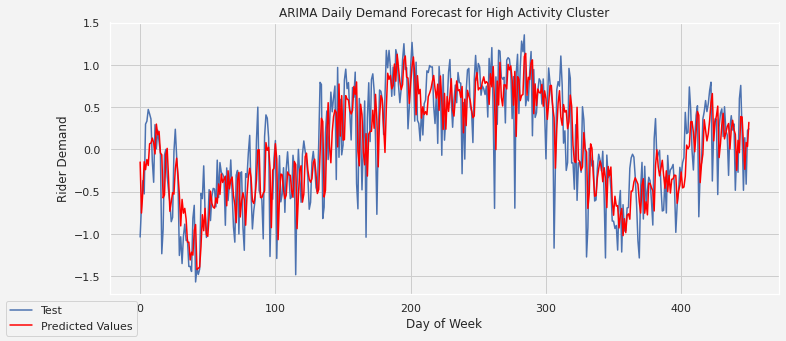

In [11]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Rider Demand')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Demand Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

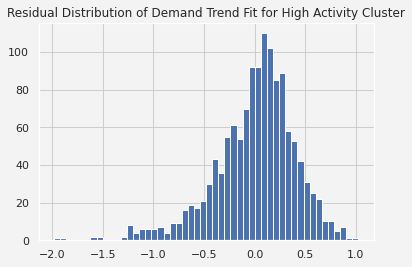

In [12]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals, bins = 50)

plt.title('Residual Distribution of Demand Trend Fit for High Activity Cluster')
plt.show

In [13]:
rider_demand_1 = pd.Series(rider_df_0[pd.IndexSlice[:,1]])

In [14]:
rider_demand_1,lam = boxcox(rider_demand_1)
rider_demand_1 = trans.fit_transform(rider_demand_1.reshape(-1,1))
rider_demand_1 = pd.DataFrame(rider_demand_1)

In [15]:
demand_cluster_1_fit, predictions, test, residuals = model_creation(rider_demand_1)

Test RMSE: 0.351
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -266.650
Date:                Sun, 20 Dec 2020   AIC                            545.300
Time:                        22:09:38   BIC                            576.426
Sample:                             0   HQIC                           556.969
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5364      0.023    -23.618      0.000      -0.581      -0.492
ar.L2         -0.4510      0.026    -17.116      0.000      -0.503      -0.399
ar.L3         -0.3373      0.031   

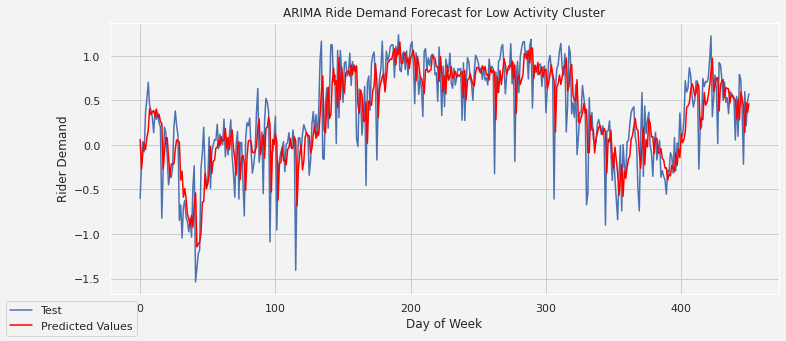

In [16]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Rider Demand')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Ride Demand Forecast for Low Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

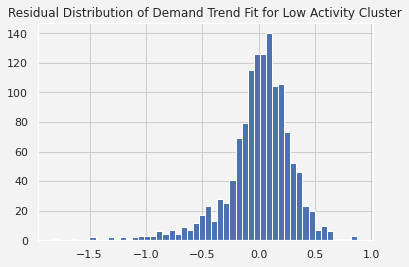

In [17]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals, bins = 50)

plt.title('Residual Distribution of Demand Trend Fit for Low Activity Cluster')
plt.show

In [18]:
rider_demand_2 = pd.Series(rider_df_0[pd.IndexSlice[:,2]])

In [19]:
rider_demand_2,lam = boxcox(rider_demand_2)
rider_demand_2 = trans.fit_transform(rider_demand_2.reshape(-1,1))
rider_demand_2 = pd.DataFrame(rider_demand_2)

In [20]:
demand_cluster_2_fit, predictions, test, residuals = model_creation(rider_demand_2)

Test RMSE: 0.451
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -694.763
Date:                Sun, 20 Dec 2020   AIC                           1401.526
Time:                        22:10:57   BIC                           1432.652
Sample:                             0   HQIC                          1413.194
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4714      0.025    -19.003      0.000      -0.520      -0.423
ar.L2         -0.4380      0.026    -16.552      0.000      -0.490      -0.386
ar.L3         -0.3922      0.028   

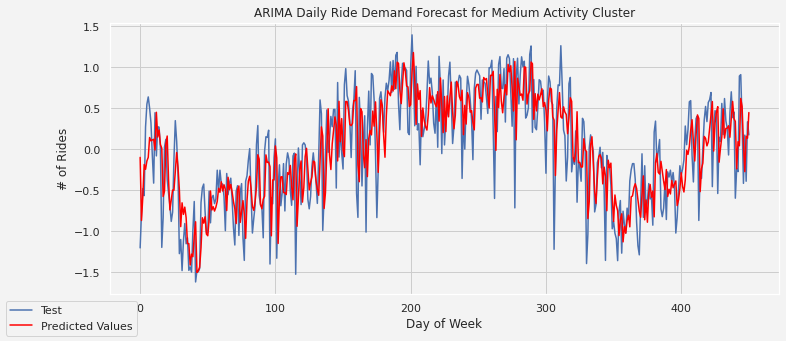

In [21]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('# of Rides')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Demand Forecast for Medium Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

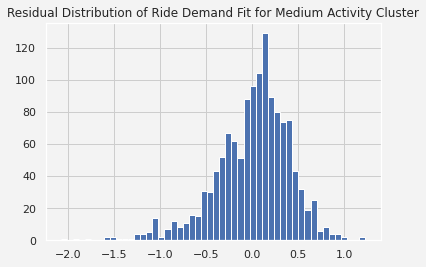

In [22]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals, bins = 50)

plt.title('Residual Distribution of Ride Demand Fit for Medium Activity Cluster')
plt.show

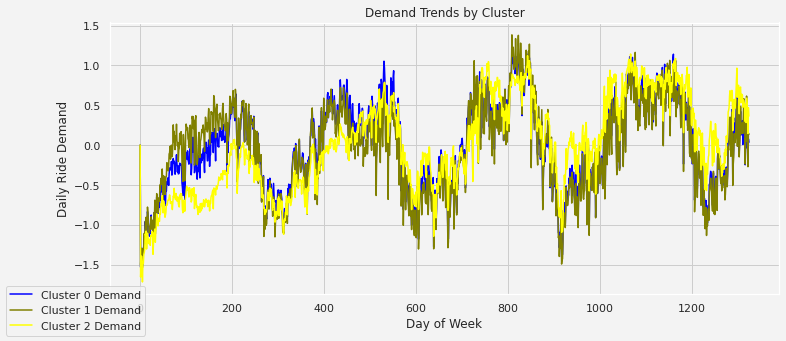

In [23]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Daily Ride Demand')
ax1.plot(demand_fit.fittedvalues, color = 'blue')
ax1.plot(demand_cluster_2_fit.fittedvalues, color='olive')


ax1.plot(demand_cluster_1_fit.fittedvalues, color='yellow')

fig.legend(['Cluster 0 Demand','Cluster 1 Demand', 'Cluster 2 Demand'], loc=3)
plt.title('Demand Trends by Cluster')
plt.show()